## Main execution file

- provided in BO-HBM-ex
- Author: Quentin Ragueneau & Luc Laurent
- url: http://github.com/RagQ/BO-HBM-ex.git
- License: MIT
- Thesis report: [https://theses.fr/2024HESAC014](https://theses.fr/2024HESAC014)
- Paper: [10.1007/s00158-024-03747-5](https://dx.doi.org/10.1007/s00158-024-03747-5)


# Information

Application of Constrained Bayesian Optimization on a Duffing Oscillator

- based on the use of BOTorch and GPyTorch for Constrained Bayesian Optimization
- based on HBM and continuation method for solving Duffing problem (see [parametric study](respDuffing.ipynb)).


# Setup

Run `pip install -r requirements.txt` before executing the notebook (required if you run it outside of `binder`)


In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import os
import time
from loguru import logger
import ipywidgets as ipw

%matplotlib ipympl

In [ ]:
plt.rcParams["text.usetex"] = True

KeyError: 'text.use_mathtext is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

In [3]:
import bogp_lib as bogp
from botorch.utils.transforms import normalize, unnormalize
from fobjDuffing import fobjDuffing as fobj

### Probleme statement

The Python's tool `BO-HBM-ex` shows an example of the application of Bayesian Optimization [1] on a Duffing problem [2]. The Duffing's oscillator problem is here solved using Harmonic Balance Method and a continuation technique.

<img src="illus/duffing_scheme.png" width="200" ><br>
Duffing oscillator scheme. 

The optimization problem can be written:

------------

Find $`(k_{nl}^*,\xi^*)`$ such as 

$`(k_{nl}^*,\xi^*)=\underset{(k_{nl},\xi)\in\mathcal{D}}{\arg\min}\,\underset{\omega\in[\omega_l,\omega_u]}{\max} \ddot{q}_{\mathrm{RMS}}(k_{nl},\xi,\omega)`$

-------------

## References
```
[1] D. R. Jones, M. Schonlau, and W. J. Welch. Efficient Global Optimization of Expensive Black-Box Functions. Journal of Global Optimization, 13(4):455–492, Dec. 1998.

[2] B. Balaram, M. D. Narayanan, and P. K. Rajendrakumar. Optimal design of multi-parametric nonlinear systems using a parametric continuation based Genetic Algorithm approach. Nonlinear Dynamics, 67(4):2759–2777, Mar. 2012.
```

### Design space


In [4]:
bounds = torch.tensor([[0.1, 0.1], [1, 2]])
# bounds defined for acquisition function (Expected Improvement) (normalized on the square [0,1])
bndaqf = torch.stack([0 * torch.ones(2), 1 * torch.ones(2)]).double()

### Reference grid considered for testing


In [5]:
xgrid = torch.linspace(bounds[0, 0], bounds[1, 0], 500).double()
ygrid = torch.linspace(bounds[0, 1], bounds[1, 1], 500).double()
Xg, Yg = torch.meshgrid(xgrid, ygrid, indexing="xy")
Xref = bogp.grid_to_array(Xg, Yg)

### Coarse reference grid considered for plotting


In [6]:
xplt = torch.linspace(bounds[0, 0], bounds[1, 0], 25).double()
yplt = torch.linspace(bounds[0, 1], bounds[1, 1], 25).double()
Xp, Yp = torch.meshgrid(xplt, yplt, indexing="xy")
Xplt = bogp.grid_to_array(Xp, Yp)

### Number of experiments for each $n_s$ (number of initial sample points)


In [7]:
nbExp = 30
# Maximum number of calls to the mechanical solver
budget = 100

### List of number of samples


In [8]:
ns_list = [10, 15, 20, 25]
ResName = "ExpOptimDuffing"

### Script to run Bayesian Optimization

- This function is ran for initial set of samples points
- The stopping criterion is based on a budget in terms of a maximum number of solver calls


In [81]:
class ExpOpti:
    def __init__(self, ns: int, budget: int = 100):
        self.ns = ns
        self.budget = budget
        self.it = 0
        self.delta = 1
        self.df = None
        self.Fg = list()
        self.EIg = list()
        self.Zbest = list()
        self.Xbest = list()
        self.Xm = list()
        self.Zm = list()
        self.XEImax = list()
        self.EImax = list()
        # create working directory
        self.init_dir(ResName, ns)
        # intialize optimization
        self.init_opti()
        # iterate
        self.iterate(budget)

    def init_dir(self, dirname: str, ns: int):
        if not os.path.exists(dirname):
            os.mkdir(dirname)
        subdirs = [name for name in os.listdir(dirname) if os.path.isdir(dirname)]
        numbers = [
            int(name[-2:])
            for name in subdirs
            if name.startswith("Ns" + f"{ns:02d}" + "_Exp")
        ]
        new_num = max(numbers) + 1 if numbers else 0
        Nname = "Ns" + f"{ns:02d}" + "_Exp" + f"{new_num:02d}"
        self.workdir = os.path.join(dirname, Nname)
        os.mkdir(self.workdir)
        logger.info("=== Current working directory: {} ===".format(self.workdir))

    def init_opti(self):
        logger.info("=== Start Optimization for ns={} ===".format(self.ns))
        # sampling of the design space using LHS
        logger.info("=== Sampling ", end="")
        tic = time.time()
        self.Xs = bogp.lhs_distrib(bounds, self.ns).double()
        logger.info("Done - {}s ===".format(time.time() - tic))
        # associated responses
        self.Zs = fobj(self.Xs)
        self.nbcalls = self.ns  # nb of calls

        # Scaling
        self.Xtest_sc = normalize(Xref, bounds)  # Normalized test grid
        self.Xplt_sc = normalize(Xplt, bounds)  # Normalized plot grid
        self.Xs_sc = normalize(self.Xs, bounds)  # Normalized samples
        self.Zs_sc, self.Sm = bogp.stdize(self.Zs)  # Normalized responses

        # Initialization
        logger.info("=== Create initial GP: ", end="")
        tic = time.time()
        self.gp_sc = bogp.initfit_GP(
            self.Xs_sc, self.Zs_sc, Noptim=100
        )  # Create initial GP model
        logger.info("Done - {}s ===".format(time.time() - tic))

        # Renormalizetion predictions
        self.Zpred_sc = bogp.get_pred(self.gp_sc, self.Xtest_sc).T
        self.Zpplt_sc = bogp.get_pred(self.gp_sc, self.Xplt_sc).T
        self.Zpred = bogp.unstdize(self.Zpred_sc, self.Sm)
        self.Zpplt = bogp.unstdize(self.Zpplt_sc, self.Sm)

        # Evaluation of the acquisition function (EI) on grids
        EI = bogp.get_EI(self.gp_sc, self.Xtest_sc)
        self.EIplt = bogp.get_EI(self.gp_sc, self.Xplt_sc)
        self.EImax.append(torch.max(EI))
        self.XEImax.append(Xref[torch.argmax(EI)])

        # Best minimum
        self.Zbest.append(torch.min(self.Zs))
        self.Xbest.append(self.Xs[torch.argmin(self.Zs)])
        self.delta = float(self.EImax[-1] / abs(self.Zbest[-1]))

        # Prepare data for visualization on grids
        self.Fg.append(self.Zpred[:, 0].reshape(Xg.shape))
        self.EIg.append(EI.reshape(Xg.shape))

    def iterate(self, budget: int):
        # Iterations
        logger.info("=== Start enrichment iterations ===")
        while self.nbcalls < budget:
            self.it += 1
            logger.info("=== Iteration: {} (ns={}) ===".format(self.it, self.ns))
            # enrichment
            logger.info("== Get new point ", end="")
            tic = time.time()
            self.gp_sc, self.Xs_sc, self.Zs_sc, self.Sm, EImax = bogp.enrich2(
                self.gp_sc,
                fobj,
                bounds,
                self.Sm,
                bndaqf,
                Noptim=100,
                num_restarts=150,
                raw_samples=150,
            )
            # self.EImax.append(EImax)
            logger.info("Done - {}s ".format(time.time() - tic))
            self.nbcalls += 1

            # Get data for visualization
            Zpred_sc = bogp.get_pred(self.gp_sc, self.Xtest_sc).T  # Prediction
            Zpplt_sc = bogp.get_pred(self.gp_sc, self.Xplt_sc).T
            Zpred = bogp.unstdize(Zpred_sc, self.Sm)
            self.Zpplt = bogp.unstdize(Zpplt_sc, self.Sm)
            EI = bogp.get_EI(self.gp_sc, self.Xtest_sc)  # EI
            self.EIplt = bogp.get_EI(self.gp_sc, self.Xplt_sc)  # EI
            self.EImax.append(torch.max(EI))
            self.XEImax.append(Xref[torch.argmax(EI)])
            self.Xm.append(unnormalize(self.Xs_sc, bounds))
            self.Zm.append(bogp.unstdize(self.Zs_sc, self.Sm))
            self.Zbest.append(torch.min(self.Zm[-1]))  # Best min
            self.Xbest.append(self.Xm[-1][torch.argmin(self.Zm[-1])])
            self.delta = float(self.EImax[-1] / abs(self.Zbest[-1]))
            # Prepare data for visualization on grids
            self.Fg.append(Zpred[:, 0].reshape(Xg.shape))
            self.EIg.append(EI.reshape(Xg.shape))


class plotting:
    def __init__(self, data, it):
        self.data = data
        self.init(it)

    def init(self, it: int = 0):
        plt.rc("font", family="serif", size=16)
        plt.rcParams["text.usetex"] = True
        self.fig = plt.figure(figsize=(12, 6), layout="constrained")
        self.ax1 = self.fig.add_subplot(2, 2, 1)
        self.ax2 = self.fig.add_subplot(2, 2, 2)
        self.ax3 = self.fig.add_subplot(2, 2, 3, projection="3d")
        self.ax4 = self.fig.add_subplot(2, 2, 4, projection="3d")

    def decorate(self, it: int):
        xlabel = r"$\xi\, [\mathrm{kg}\cdot\mathrm{s}^{-1}]$"
        ylabel = r"$k_{nl}\, [\mathrm{N}\cdot\mathrm{m}^{-3}]$"
        self.ax1.set_xlim(0.1, 1)
        self.ax1.set_ylim(0.1, 2)
        self.ax1.set_xlabel(xlabel)
        self.ax1.set_ylabel(ylabel)
        self.ax2.set_xlim(0.1, 1)
        self.ax2.set_ylim(0.1, 2)
        self.ax2.set_xlabel(xlabel)
        self.ax2.set_ylabel(ylabel)
        self.ax3.set_xlim(0.1, 1)
        self.ax3.set_ylim(0.1, 2)
        self.ax3.set_xlabel(xlabel)
        self.ax3.set_ylabel(ylabel)
        self.ax3.set_zlabel(r"$F_{\mathrm{obj}}(\xi,k_{nl})$")
        self.ax4.set_xlim(0.1, 1)
        self.ax4.set_ylim(0.1, 2)
        self.ax4.set_xlabel(xlabel)
        self.ax4.set_ylabel(ylabel)
        self.ax4.set_zlabel(r"$EI(\xi,k_{nl})$")
        self.ax1.set_title(r"Objective Function - it. {}".format(it))
        self.ax2.set_title(r"Expected Improvement - it. {}".format(it))
        self.ax3.set_title(r"Objective Function - it. {}".format(it))
        self.ax4.set_title(r"Expected Improvement - it. {}".format(it))
        #
        # self.plot(it)

    def plot(self, it: int = 0):
        self.ax1.cla()
        self.ax2.cla()
        self.ax3.cla()
        self.ax4.cla()
        self.decorate(it)
        # plot 2D objective function
        CSF = self.ax1.contour(
            Xg,
            Yg,
            self.data.Fg[it],
            cmap=plt.cm.viridis,
            levels=numpy.linspace(0, 2, 21),
        )
        self.ax1.clabel(
            CSF,
            levels=numpy.linspace(0, 2, 11),
            inline=1,
            inline_spacing=0,
            fontsize=15,
        )

        self.ax1.plot(  # Initial Samples
            self.data.Xs[:, 0],
            self.data.Xs[:, 1],
            "D",
            label="Initial Samples",
            color="tab:red",
            zorder=100,
            markersize=8,
        )
        if it > 1:
            self.ax1.plot(  # Added Samples
                numpy.array(self.data.Xm[it - 1][self.data.ns : -1, 0]),
                numpy.array(self.data.Xm[it - 1][self.data.ns : -1, 1]),
                # numpy.array(self.data.Zm[it-1][self.data.ns:-1, 0]),
                marker="o",
                linestyle="None",
                label="Added Samples",
                color="tab:red",
                zorder=100,
                markersize=8,
            )
        if it > 0:
            self.ax1.plot(  # New point
                self.data.Xm[it - 1][-1, 0],
                self.data.Xm[it - 1][-1, 1],
                # self.data.Zm[it-1][-1,0],
                marker="s",
                linestyle="None",
                label="New Sample",
                color="#ccff00",
                zorder=100,
                markersize=8,
            )
        self.ax1.scatter(
            self.data.Xbest[it][0],
            self.data.Xbest[it][1],
            marker="$\\bigodot$",
            color="black",
            linestyle="None",
            zorder=90,
            label="Minimum",
            s=384,
            alpha=1,
        )
        # plot 2D Expected Improvement
        CSCEI = self.ax2.contour(
            Xg, Yg, numpy.exp(self.data.EIg[it]), cmap=plt.cm.YlOrRd, levels=50
        )
        self.ax2.plot(
            self.data.XEImax[it][0],
            self.data.XEImax[it][1],
            "o",
            color="tab:green",
            zorder=100,
            markersize=8,
        )
        if it > 1:
            self.ax2.plot(  # Added Samples
                numpy.array(self.data.Xm[it - 1][self.data.ns : -1, 0]),
                numpy.array(self.data.Xm[it - 1][self.data.ns : -1, 1]),
                # numpy.array(self.data.Zm[it-1][self.data.ns:-1, 0]),
                marker="o",
                linestyle="None",
                label="Added Samples",
                color="tab:red",
                zorder=100,
                markersize=8,
            )
        if it > 0:
            self.ax2.plot(  # New point
                self.data.Xm[it - 1][-1, 0],
                self.data.Xm[it - 1][-1, 1],
                # self.data.Zm[it-1][-1,0],
                marker="s",
                linestyle="None",
                label="New Sample",
                color="#ccff00",
                zorder=100,
                markersize=8,
            )
        # plot 3D objective function
        self.ax3.plot_surface(Xg, Yg, self.data.Fg[it], cmap=plt.cm.viridis)
        self.ax3.plot(  # Initial Samples
            numpy.array(self.data.Xs[:, 0]),
            numpy.array(self.data.Xs[:, 1]),
            numpy.array(self.data.Zs[:, 0]),
            marker="D",
            linestyle="None",
            label="Initial Samples",
            color="tab:red",
            zorder=100,
            markersize=8,
        )
        if it > 1:
            self.ax3.plot(  # Added Samples
                numpy.array(self.data.Xm[it - 1][self.data.ns : -1, 0]),
                numpy.array(self.data.Xm[it - 1][self.data.ns : -1, 1]),
                numpy.array(self.data.Zm[it - 1][self.data.ns : -1, 0]),
                marker="o",
                linestyle="None",
                label="Added Samples",
                color="tab:red",
                zorder=100,
                markersize=8,
            )
        if it > 0:
            self.ax3.plot(  # New point
                self.data.Xm[it - 1][-1, 0],
                self.data.Xm[it - 1][-1, 1],
                self.data.Zm[it - 1][-1, 0],
                marker="s",
                linestyle="None",
                label="New Sample",
                color="#ccff00",
                zorder=100,
                markersize=8,
            )
        self.ax3.scatter(
            self.data.Xbest[it][0],
            self.data.Xbest[it][1],
            self.data.Zbest[it],
            marker="$\\bigodot$",
            color="black",
            linestyle="None",
            zorder=90,
            label="Minimum",
            s=384,
            alpha=1,
        )

        # plot 3D Expected Improvement
        self.ax4.plot_surface(Xg, Yg, numpy.exp(self.data.EIg[it]), cmap=plt.cm.viridis)
        self.ax4.plot(
            self.data.XEImax[it][0],
            self.data.XEImax[it][1],
            numpy.exp(self.data.EImax[it]),
            marker="o",
            linestyle="None",
            color="tab:green",
            zorder=100,
            markersize=8,
        )


### Run Bayesian Optimization 
    - `ns` is the number of initial sample points
    - `budget` is the maximum number of solver calls including the initial sample points (`budget` must be larger than `ns`)

In [82]:
data = ExpOpti(ns=5, budget=20)

2025-03-19 22:14:47.688 | INFO     | __main__:init_dir:36 - === Current working directory: ExpOptimDuffing/Ns05_Exp48 ===
2025-03-19 22:14:47.689 | INFO     | __main__:init_opti:39 - === Start Optimization for ns=5 ===
2025-03-19 22:14:47.689 | INFO     | __main__:init_opti:41 - === Sampling 
2025-03-19 22:14:47.692 | INFO     | __main__:init_opti:44 - Done - 0.0024521350860595703s ===
2025-03-19 22:14:50.259 | INFO     | __main__:init_opti:56 - === Create initial GP: 
2025-03-19 22:14:50.450 | INFO     | __main__:init_opti:61 - Done - 0.19049596786499023s ===
2025-03-19 22:14:50.581 | INFO     | __main__:iterate:86 - === Start enrichment iterations ===
2025-03-19 22:14:50.581 | INFO     | __main__:iterate:89 - === Iteration: 1 (ns=5) ===
2025-03-19 22:14:50.581 | INFO     | __main__:iterate:91 - == Get new point 
2025-03-19 22:14:51.284 | INFO     | __main__:iterate:104 - Done - 0.702254056930542s 
2025-03-19 22:14:51.376 | INFO     | __main__:iterate:89 - === Iteration: 2 (ns=5) ===


#### Analysis of Optimization iterations

interactive(children=(IntSlider(value=0, description='Iteration', max=15), Output()), _dom_classes=('widget-in…

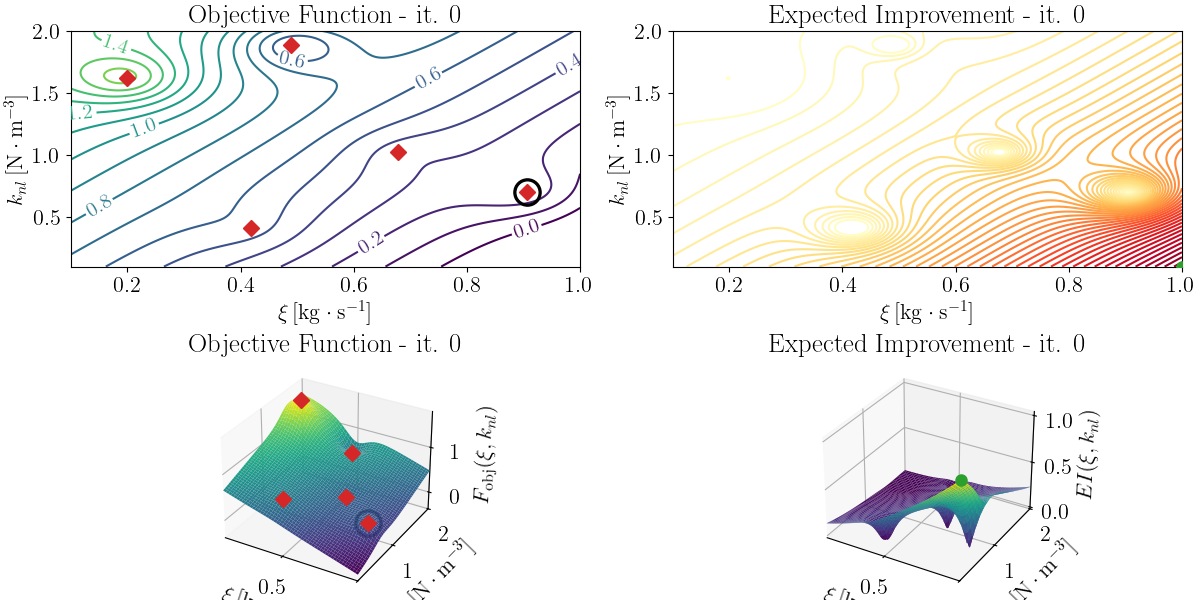

In [98]:

plot = plotting(data, 0)

it_slider = ipw.IntSlider(min=0, 
                          max=data.it, 
                          step=1, 
                          value=0, 
                          description="Iteration")
play = ipw.Play(
    value=0,
    min=0,
    max=data.it,
    step=1,
    interval=10000,
    description="Press play",
    disabled=False
)
ipw.jslink((play, 'value'), (it_slider, 'value'))
ui =ipw.HBox([play])
gui = ipw.interactive(plot.plot, it=it_slider)
display(gui,ui)
